In [8]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.cm as cm
import os,sys
sys.path.append(os.path.realpath('FGW distance on graph/lib'))
from graph import Graph
from ot_distances import Fused_Gromov_Wasserstein_distance

%load_ext autoreload
%autoreload 2

%matplotlib inline

from synthetic_graphs import *
from solver import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


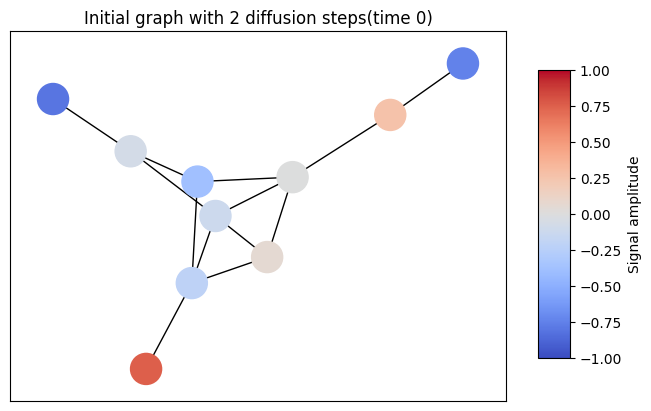

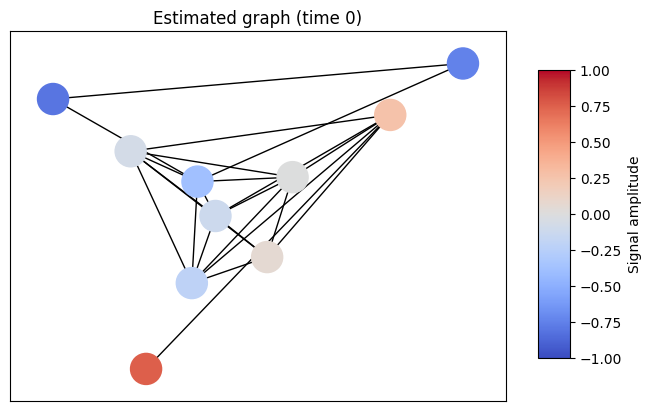

In [16]:
# Graph generation
# Input parameters
num_nodes = 10
num_edges = 13
value_range = (-1, 1)
diffusion_time = 2
# Create the initial graph
G0 = create_graph(num_nodes, num_edges, value_range, edge_weight_range = [1,1])
# Perform diffusion
G = diffusion(G0,  diffusion_steps = diffusion_time)

# Graph signal generation
# Signal parameters
num_samples = 20
noise_std = 0.2
# Generation
graph_signal = sample_signal_from_graph(G, num_samples, noise_std)

# Solver
# Solver parameters
max_iter = 1000
alpha = 1e-3
beta = 2e-3
solvers.options['show_progress'] = False
np.random.seed(3)
# Solving
L_est, Y_est = gl_sig_model(graph_signal, max_iter, alpha, beta)

# Generate graph from Laplacian
G_est = create_graph_from_laplacian(L_est, 1)
for node in G_est.nodes():
    G_est.nodes[node]['value'] = G.nodes[node]['value'] #add signal
    G_est.nodes[node]['pos'] = G.nodes[node]['pos'] #keep same position as initial
for edge in G_est.edges():
    G_est[edge[0]][edge[1]]['weight'] = 1 #Add weight of 1 (not etsimated)

plot_graph(G, value_range=value_range, labels=False, title=f"Initial graph with {diffusion_time} diffusion steps(time 0)")
plot_graph(G_est, value_range=value_range, labels=False, title="Estimated graph (time 0)")

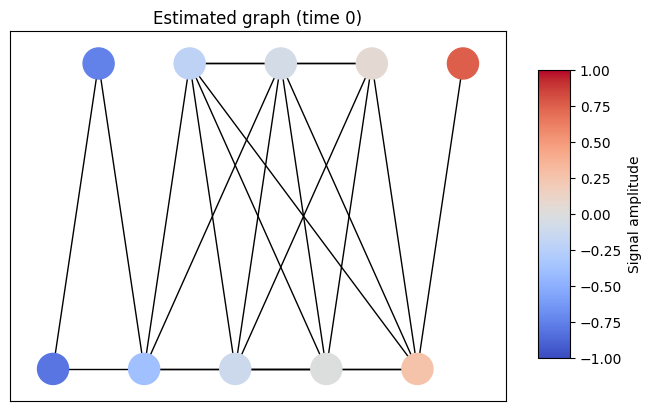

In [17]:
signal_init = [G_est.nodes[node]['value'] for node in G_est.nodes]
edges = G_est.nodes

# Sort the two lists by signal values
combined = list(zip(signal_init, edges))
combined.sort(key=lambda x: x[0])
signal, edges = zip(*combined)

pos = [ [i, 0 if i%2 == 0 else 1] for i in range(len(edges))]

for i in range(len(edges)) :
    G_est.nodes[edges[i]]['pos'] = pos[i]
plot_graph(G_est, value_range=value_range, labels=False, title="Estimated graph (time 0)")


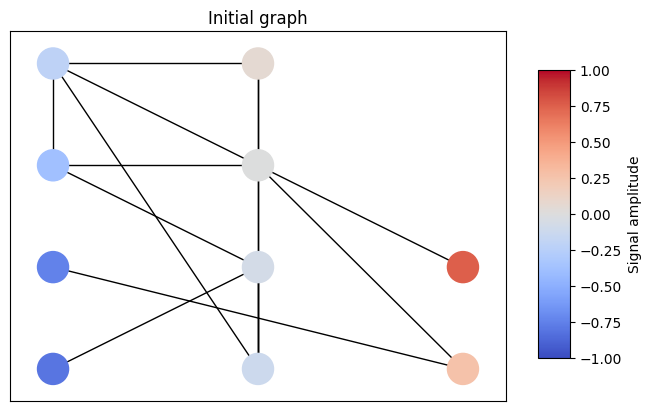

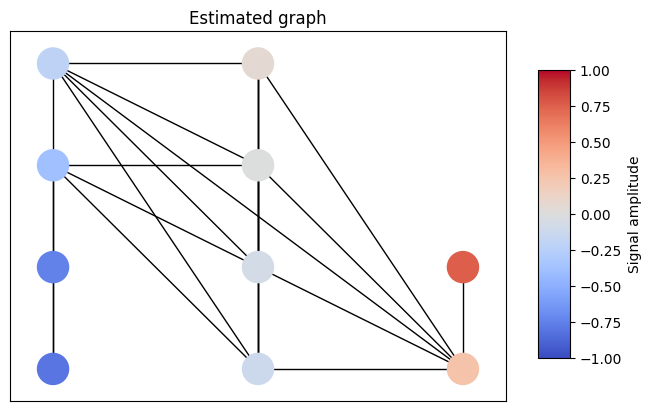

In [18]:
side_length = int(np.ceil(np.sqrt(len(G.nodes))))
pos_2D = [(x, y) for x in range(side_length) for y in range(side_length)]

signal = [G.nodes[node]['value'] for node in G_est.nodes]
edges = G.nodes
# Sort the two lists by signal values
combined = list(zip(signal_init, edges))
combined.sort(key=lambda x: x[0])
signal, edges = zip(*combined)
for i in range(len(edges)) :
    G.nodes[edges[i]]['pos'] = [pos_2D[i][0], pos_2D[i][1]]
    G_est.nodes[edges[i]]['pos'] = [pos_2D[i][0], pos_2D[i][1]]

plot_graph(G, value_range=value_range, labels=False, title="Initial graph")
plot_graph(G_est, value_range=value_range, labels=False, title="Estimated graph")


In [ ]:
def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Turn gridlines off
    ax.grid(False)
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

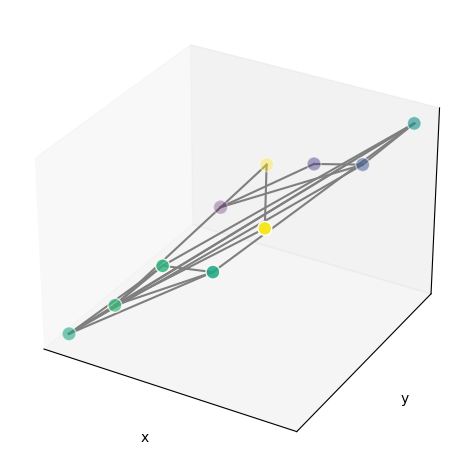

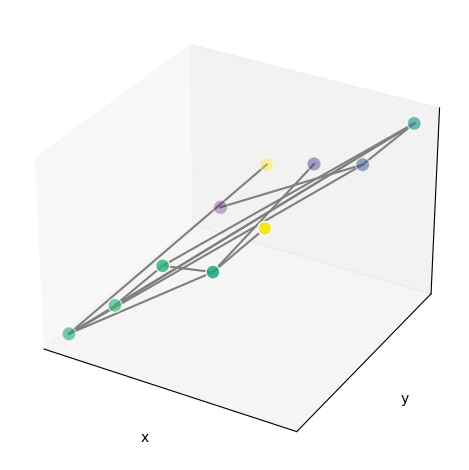

In [27]:
side_length = int(np.ceil(np.sqrt(len(G.nodes))))
pos_2D = [(x, y) for x in range(side_length) for y in range(side_length)]

signal = [G.nodes[node]['value'] for node in G_est.nodes]
edges = G.nodes
# Sort the two lists by signal values
combined = list(zip(signal_init, edges))
combined.sort(key=lambda x: x[0])
signal, edges = zip(*combined)
for i in range(len(edges)) :
    G.nodes[edges[i]]['pos'] = [pos_2D[i][0], pos_2D[i][1], signal[i]]
    G_est.nodes[edges[i]]['pos'] = [pos_2D[i][0], pos_2D[i][1], signal[i]]

# Extract node and edge positions from the layout
node_xyz_G = np.array([G.nodes[node]['pos'] for node in G.nodes])
edge_xyz_G = np.array([(G.nodes[nodeu]['pos'], G.nodes[nodev]['pos']) for nodeu, nodev in G.edges()])
node_xyz_G_est = np.array([G_est.nodes[node]['pos'] for node in G_est.nodes])
edge_xyz_G_est = np.array([(G_est.nodes[nodeu]['pos'], G_est.nodes[nodev]['pos']) for nodeu, nodev in G_est.edges()])

# Create the 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(*node_xyz_G.T, c=[G.nodes[node]['value'] for node in G.nodes], s=100, ec="w")
cbar = plt.colorbar(scatter)
cbar.set_label('Signal value')
for vizedge in edge_xyz_G:
    ax.plot(*vizedge.T, color="tab:gray")
_format_axes(ax)
fig.tight_layout()
plt.title("True graph")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(*node_xyz_G_est.T, c=[G.nodes[node]['value'] for node in G_est.nodes], s=100, ec="w")
cbar = plt.colorbar(scatter)
cbar.set_label('Signal value')
for vizedge in edge_xyz_G_est:
    ax.plot(*vizedge.T, color="tab:gray")
_format_axes(ax)
fig.tight_layout()
plt.title("Constructed graph")
plt.show()